# Further analysis of the gut uLIPSTIC dataset: focusing on the CD4 subset

In [74]:
from helper_functions import *
from pandas.api.types import CategoricalDtype
from plotnine import * 
from scipy.cluster.hierarchy import dendrogram,linkage, set_link_color_palette
from scipy.stats import gmean, mannwhitneyu

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sc.set_figure_params(figsize=(5,4), vector_friendly=False)

In [75]:
ad  = sc.read_h5ad("iel_tcr_feb21.h5ad")

In [76]:
ad.obsm["X_umap_full"] = ad.obsm["X_umap"].copy()

In [77]:
## cluster 19 is similar to CD4 T cell clusters 8 and 9 (based on the dendrogram, in supplement), include it for now
ad = ad[(ad.obs.annotation == "CD4") | (ad.obs.leiden == "19")] 
ad.shape

(944, 14332)

## build new neighborhood graph just on CD4 T cells

In [78]:
ad.X = ad.layers["pearson_theta_1"].copy()

In [79]:
## use saved ad

In [80]:
?sc.pp.neighbors

In [81]:
sc.pp.neighbors(ad, n_neighbors=30, n_pcs=40, use_rep='X_pca',)
sc.tl.leiden(ad, resolution=1.3)
sc.tl.umap(ad)

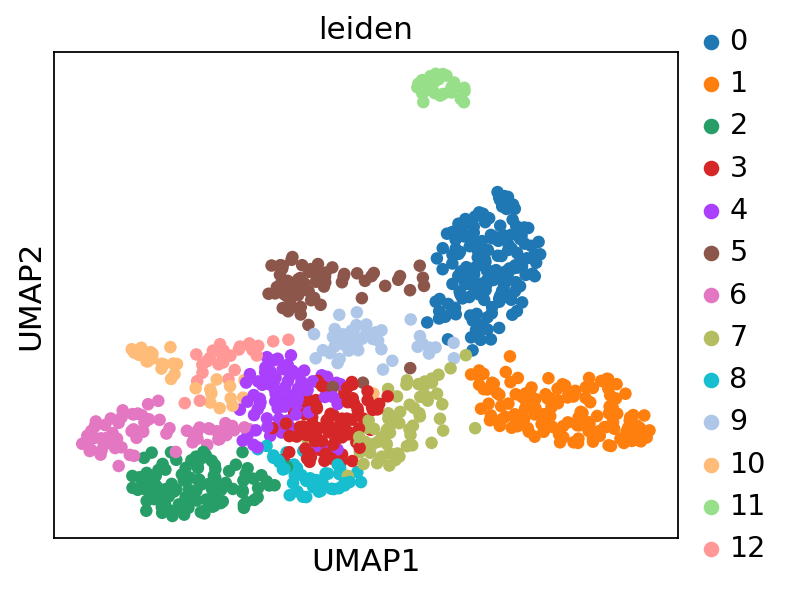

In [82]:
sc.pl.umap(ad, color = "leiden")

## plot on original UMAP

In [83]:
ad.obsm["X_umap_cd4"] = ad.obsm["X_umap"].copy()
ad.obsm["X_umap"] = ad.obsm["X_umap_full"].copy()

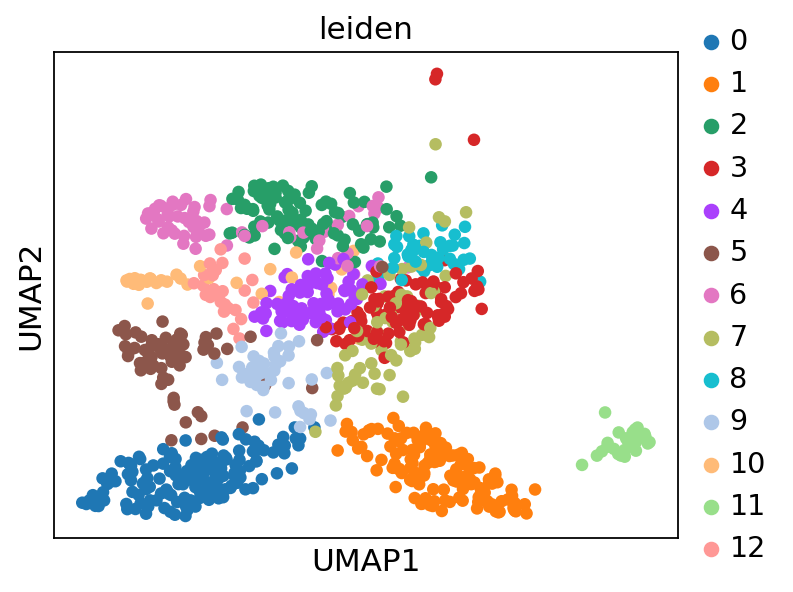

In [84]:
sc.pl.umap(ad, color = "leiden")

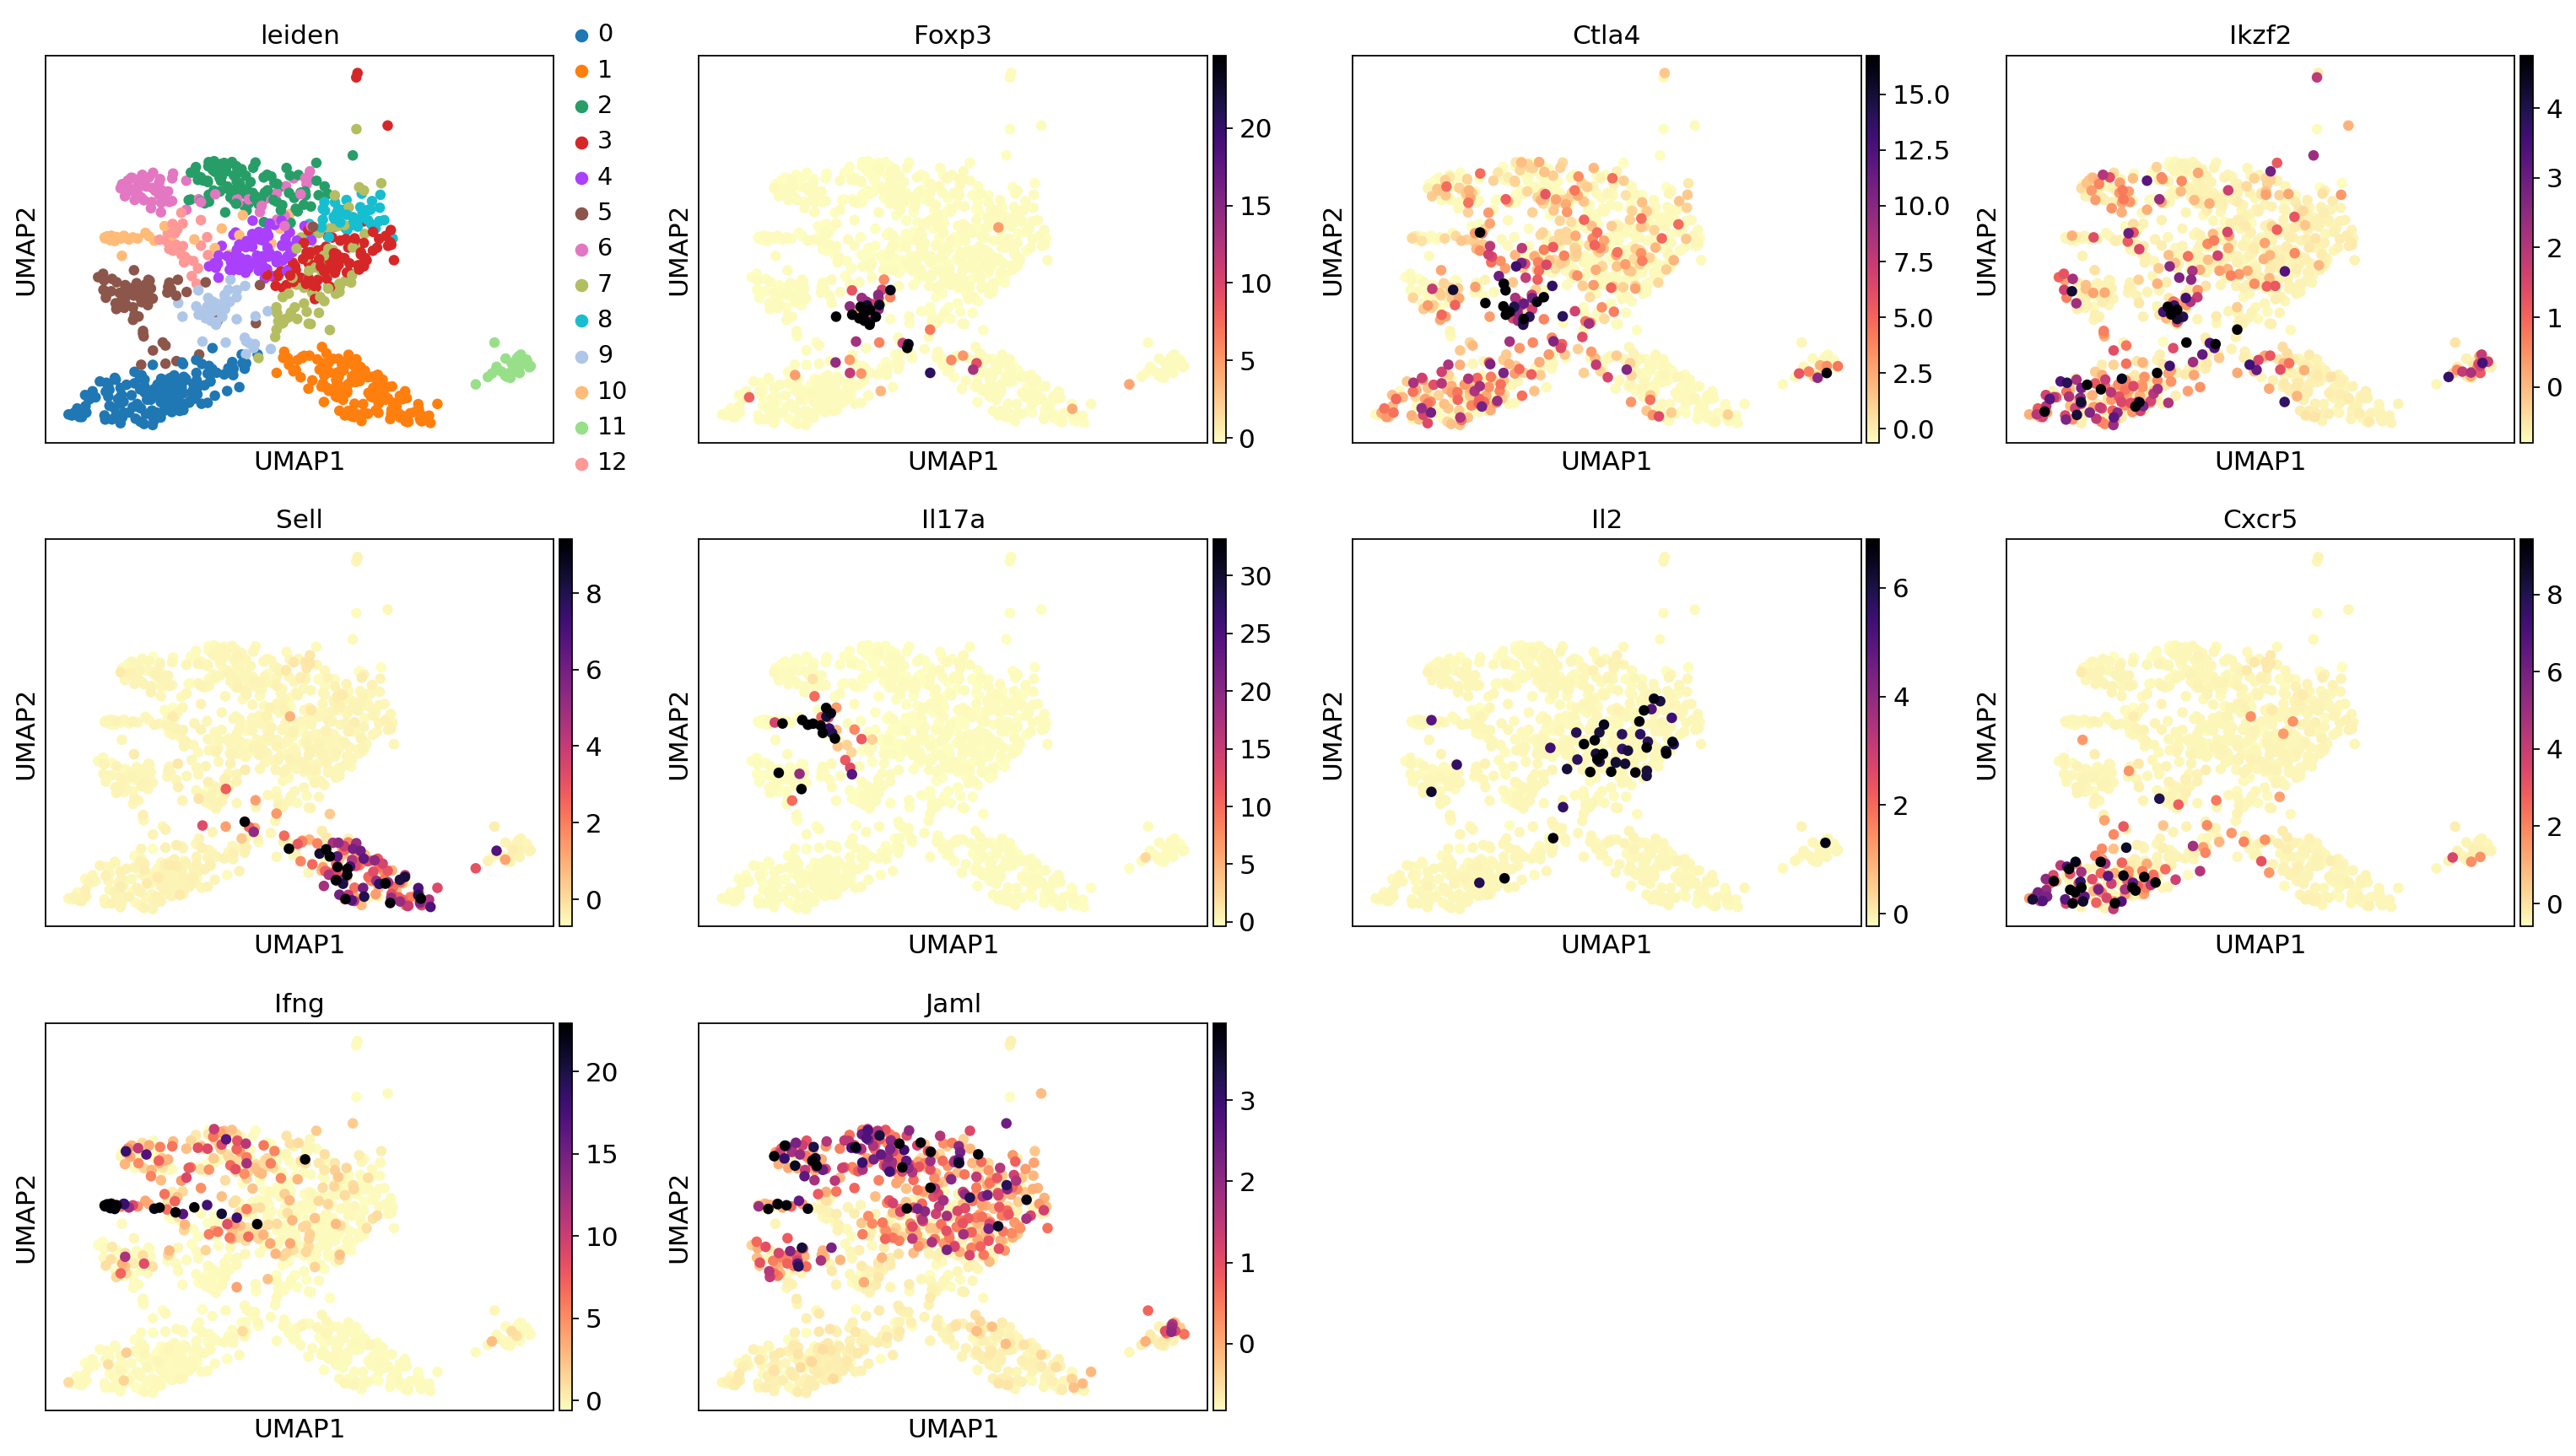

In [164]:
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.umap(ad, color = ["leiden", "Foxp3", "Ctla4", "Ikzf2", "Sell",  "Il17a", "Il2", "Cxcr5", "Ifng", "Jaml"],
          vmin="p1", vmax="p99", save="_leiden_gex.pdf", cmap="magma_r") 

## show that some of these clusters have shared clones (part of the same annotations)

##  annotate these clusters

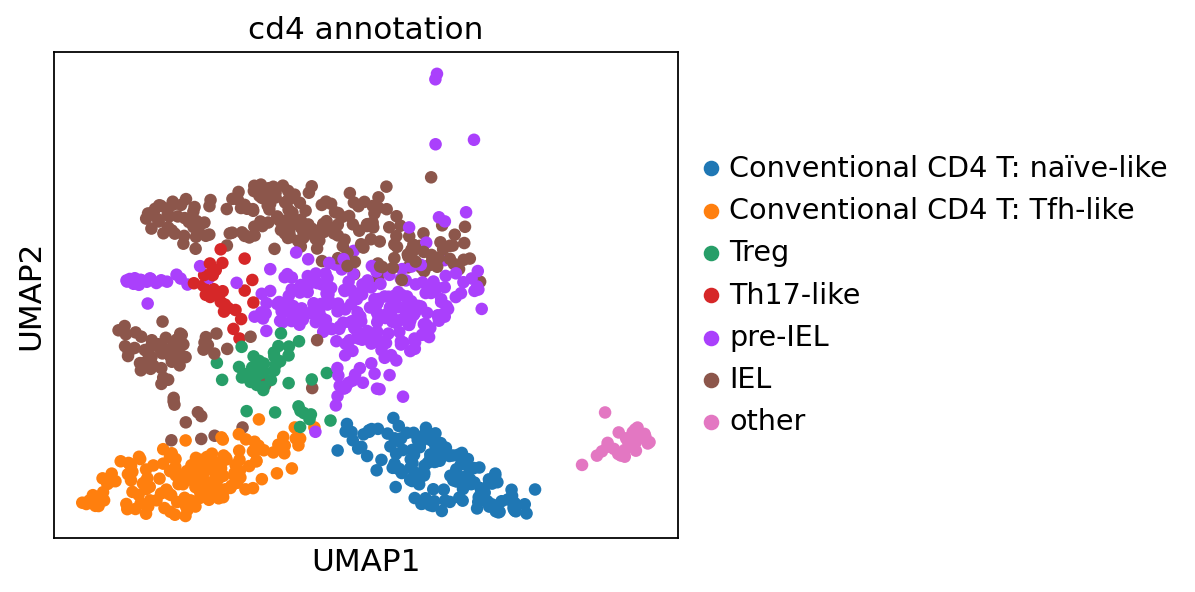

In [86]:

from pandas.api.types import CategoricalDtype

## IEL, for top, and that other one,
## pre-IEL for ones on the right, including the knob thing
## conventional for the 2 bottom ones (naïve-like, Tfh-like )
## tregs
def annotate(cl) :
    c = int(cl)
    if c == 0:
        return "Conventional CD4 T: Tfh-like"
    elif c == 1:
        return "Conventional CD4 T: naïve-like"
    elif c == 9:
        return "Treg"
    elif c == 12:
        return "Th17-like"
    elif c in [5, 6, 2, 8]:
        return "IEL"
    elif c  == 11:
        return "other"
    return "pre-IEL"
ad.obs["cd4 annotation"] = [annotate(cl) for cl in ad.obs.leiden]
ad.obs["cd4 annotation"] = ad.obs["cd4 annotation"].astype(CategoricalDtype(
    categories=["Conventional CD4 T: naïve-like", "Conventional CD4 T: Tfh-like", 
                "Treg", "Th17-like", "pre-IEL", "IEL", "other"], ordered = True))
sc.pl.umap(ad, color="cd4 annotation")

## <font color = "navy"> Supplemental figure

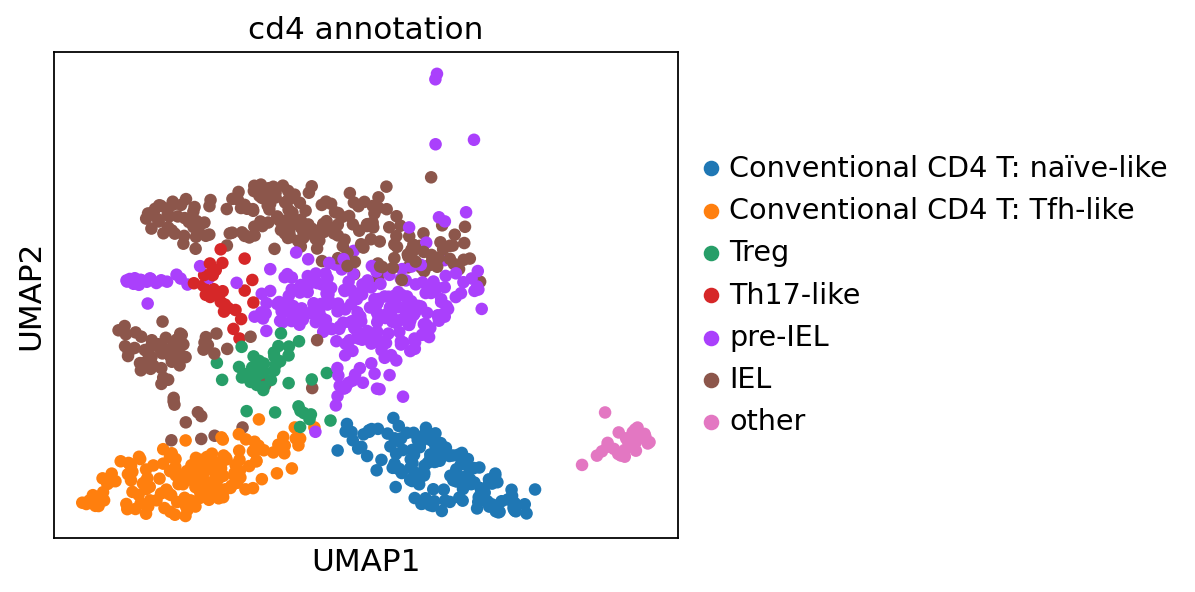

In [87]:
sc.pl.umap(ad, color="cd4 annotation")

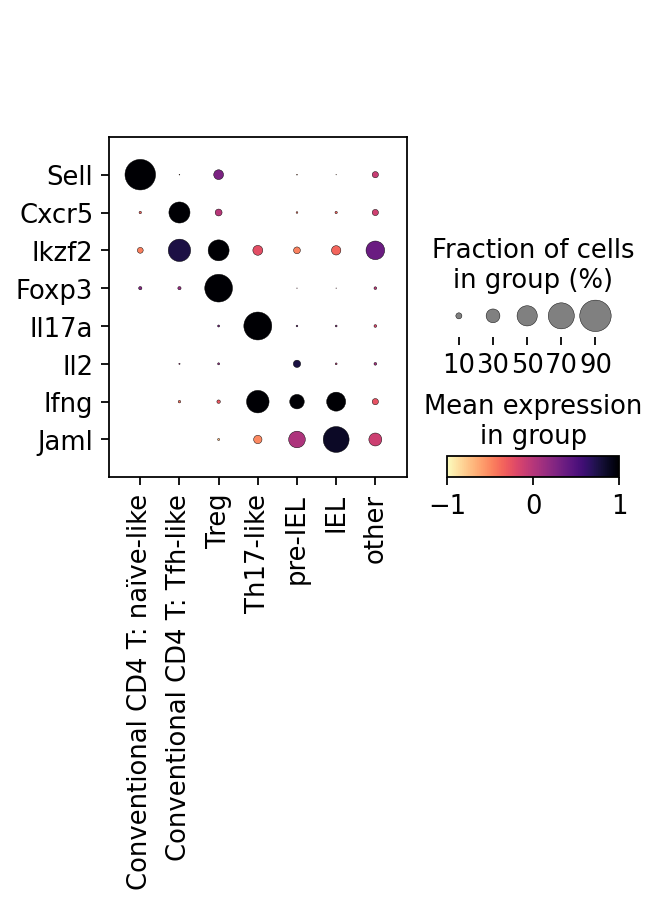

In [168]:
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.dotplot(ad, swap_axes=True, groupby="cd4 annotation", norm = mpl.colors.Normalize(vmin=-1, vmax=1), 
              cmap="magma_r", var_names = ["Sell",  "Cxcr5", "Ikzf2","Foxp3", "Il17a", "Il2", "Ifng", "Jaml"], 
              save="cd4_gex.pdf")

In [16]:
# remove the other weird cluster, still not sure what it is
ad = ad[ad.obs["cd4 annotation"] != "other"].copy()

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (944×944).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


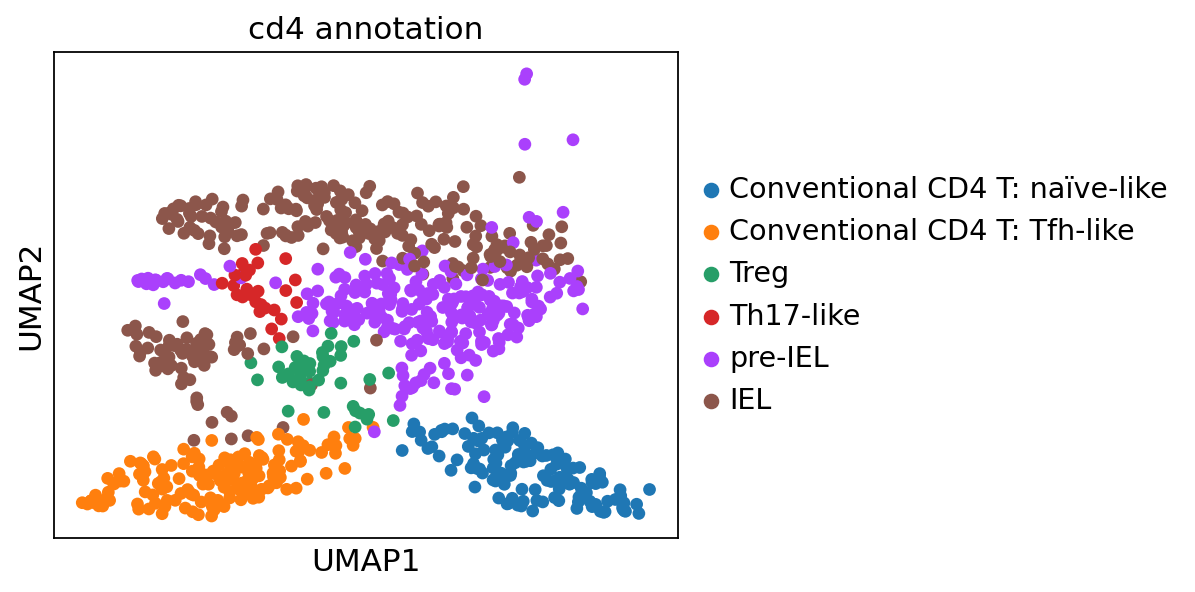

In [17]:
sc.pl.umap(ad, color = "cd4 annotation")

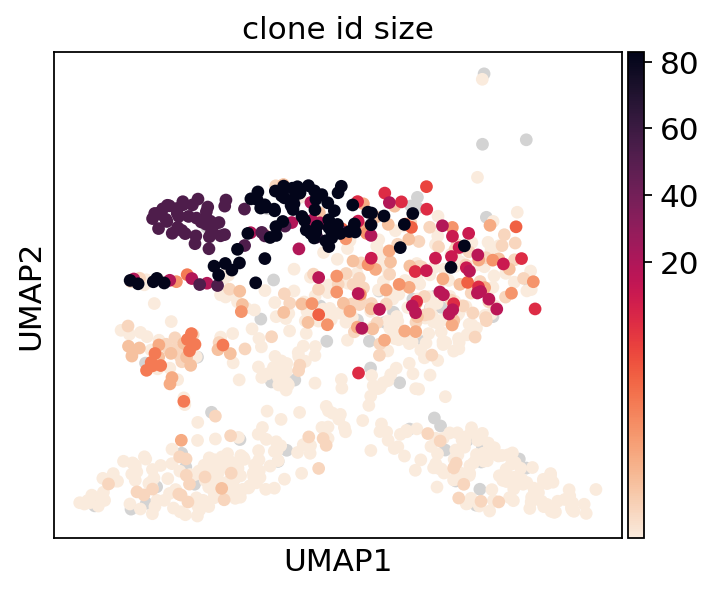

In [18]:
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.umap(ad, color = "clone_id_size", color_map="rocket_r", vmin="p2",
          vmax="p98", vcenter=10,  title="clone id size",
          save="_cd4_cloneid_size.pdf") 

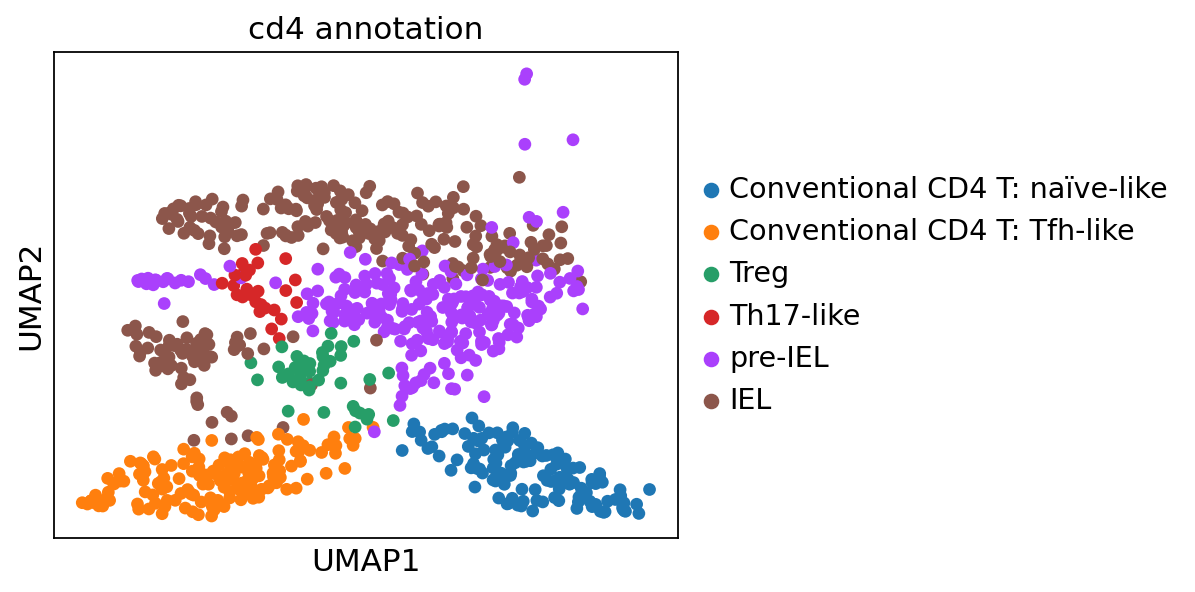

In [19]:
sc.settings.figdir="paper_figures"
sc.settings.plot_suffix = ""
sc.pl.umap(ad, color = "cd4 annotation", save="panel_4.pdf")

## explore some clones, see how they are shared across cell types/clusters

['pre-IEL', 'IEL', 'Treg']

In [110]:
ad.uns["cd4 annotation_colors"]

['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2']

5

['Conventional CD4 T: naïve-like',
 'Conventional CD4 T: Tfh-like',
 'Treg',
 'Th17-like',
 'pre-IEL',
 'IEL',
 'other']

In [154]:
def make_cl_plot(level="cd4 annotation"):
    df = pd.DataFrame()
    for cl in ["3", "4", "5","8", "12"]:
        filtered_ad = ad[ad.obs.clone_id.isin(ad.obs[ad.obs.leiden == cl][["clone_id"]].dropna().clone_id.unique())]
        filtered_ad.obs.clone_id = filtered_ad.obs.clone_id.astype(CategoricalDtype(
            categories = filtered_ad.obs.sort_values("clone_id_size", ascending=False)["clone_id"].astype(
                str).unique(), ordered = True))
        new_df = filtered_ad.obs[[level, "clone_id", "clone_id_size"]]
        new_df["cluster"] = cl
        df = pd.concat([df, new_df])
    levels = [ np.where(ad.obs[level].cat.categories == cl)[0][0] for cl in np.unique(df[level])]
    df["clone_id"] = df["clone_id"].astype(CategoricalDtype(
        ordered = True, categories=df.sort_values("clone_id_size", ascending = False)["clone_id"].unique()))
    print(levels)
    return ggplot(df, aes(x="clone_id", fill=level)) + geom_bar() + facet_wrap("~ cluster", scales="free") + \
    theme(axis_text_x = element_blank(), dpi = 200, axis_ticks_major_x=element_blank(), 
          subplots_adjust={'wspace':0.4}, ) + scale_fill_manual(np.array(ad.uns["%s_colors"%level])[[levels]]) 

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (944×944).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/pandas/core/generic.py:5604: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_65013/4286080621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During 

[1, 5, 3, 2, 4]


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


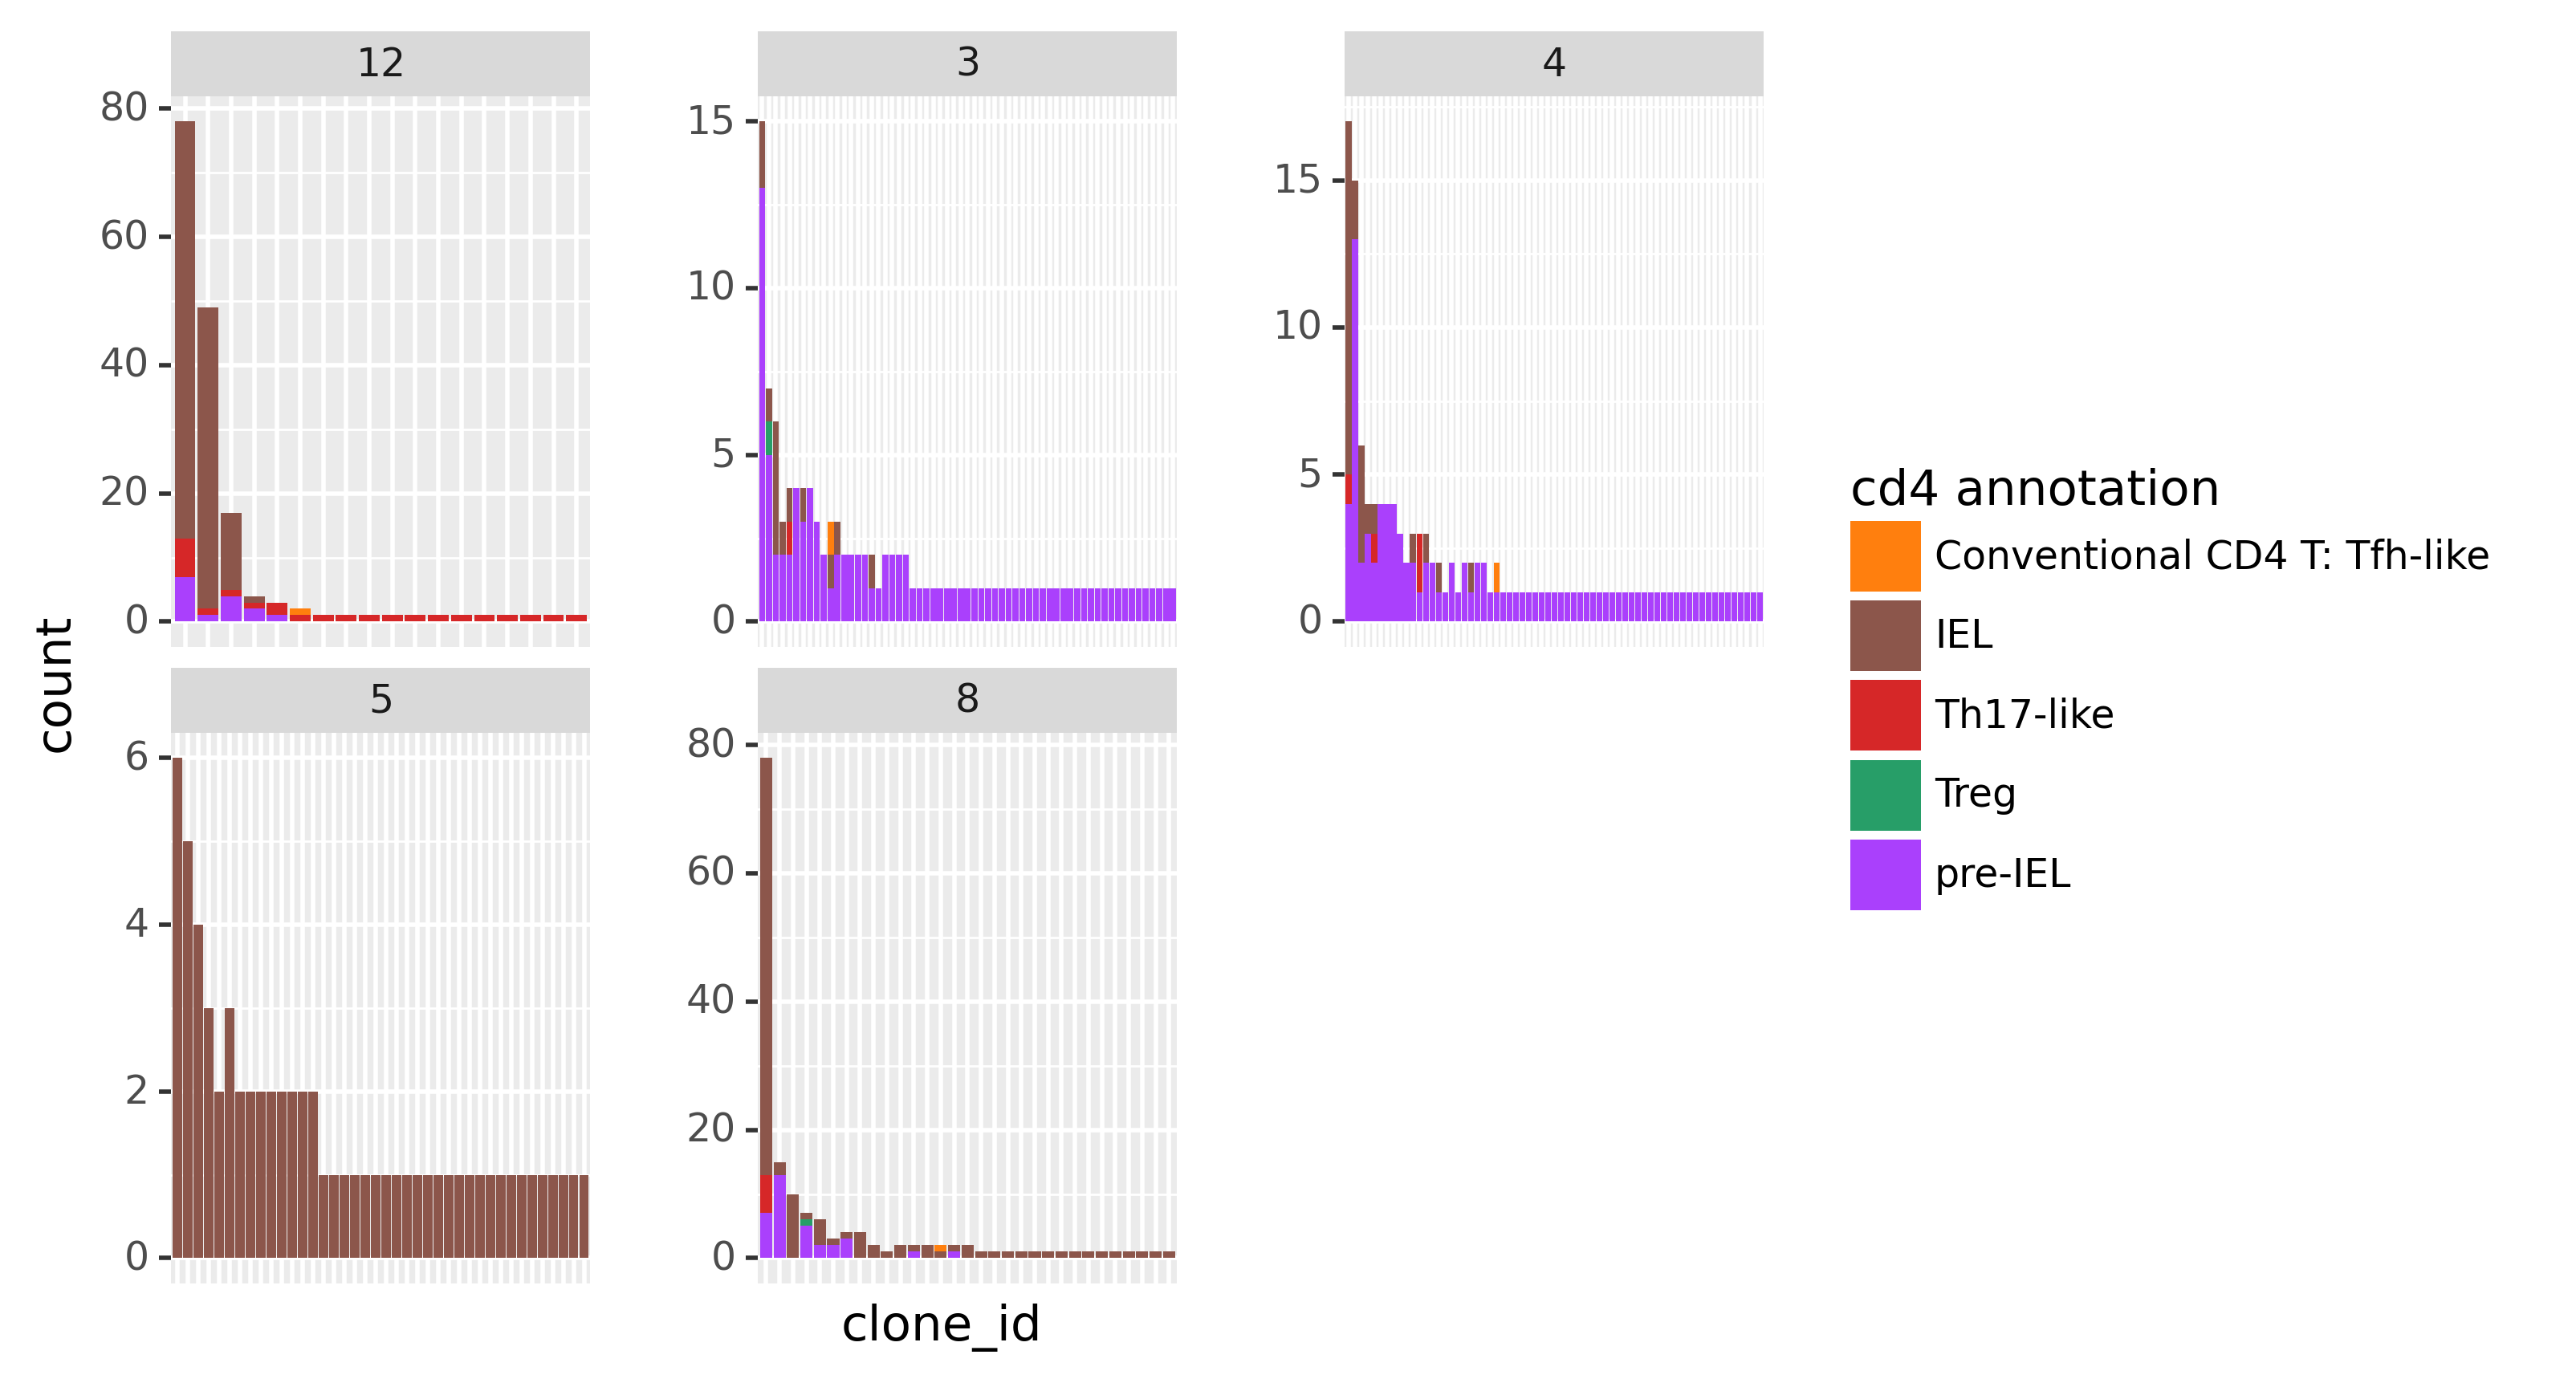

<ggplot: (8746611694951)>

In [155]:
p = make_cl_plot()
p

In [156]:
ggsave(p, "paper_figures/supplemental/cd4/clone_sharing_annotation.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/clone_sharing_annotation.pdf
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (944×944).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/pandas/core/generic.py:5604: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_65013/4286080621.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During 

[0, 10, 12, 2, 3, 4, 5, 6, 7, 8, 9]


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


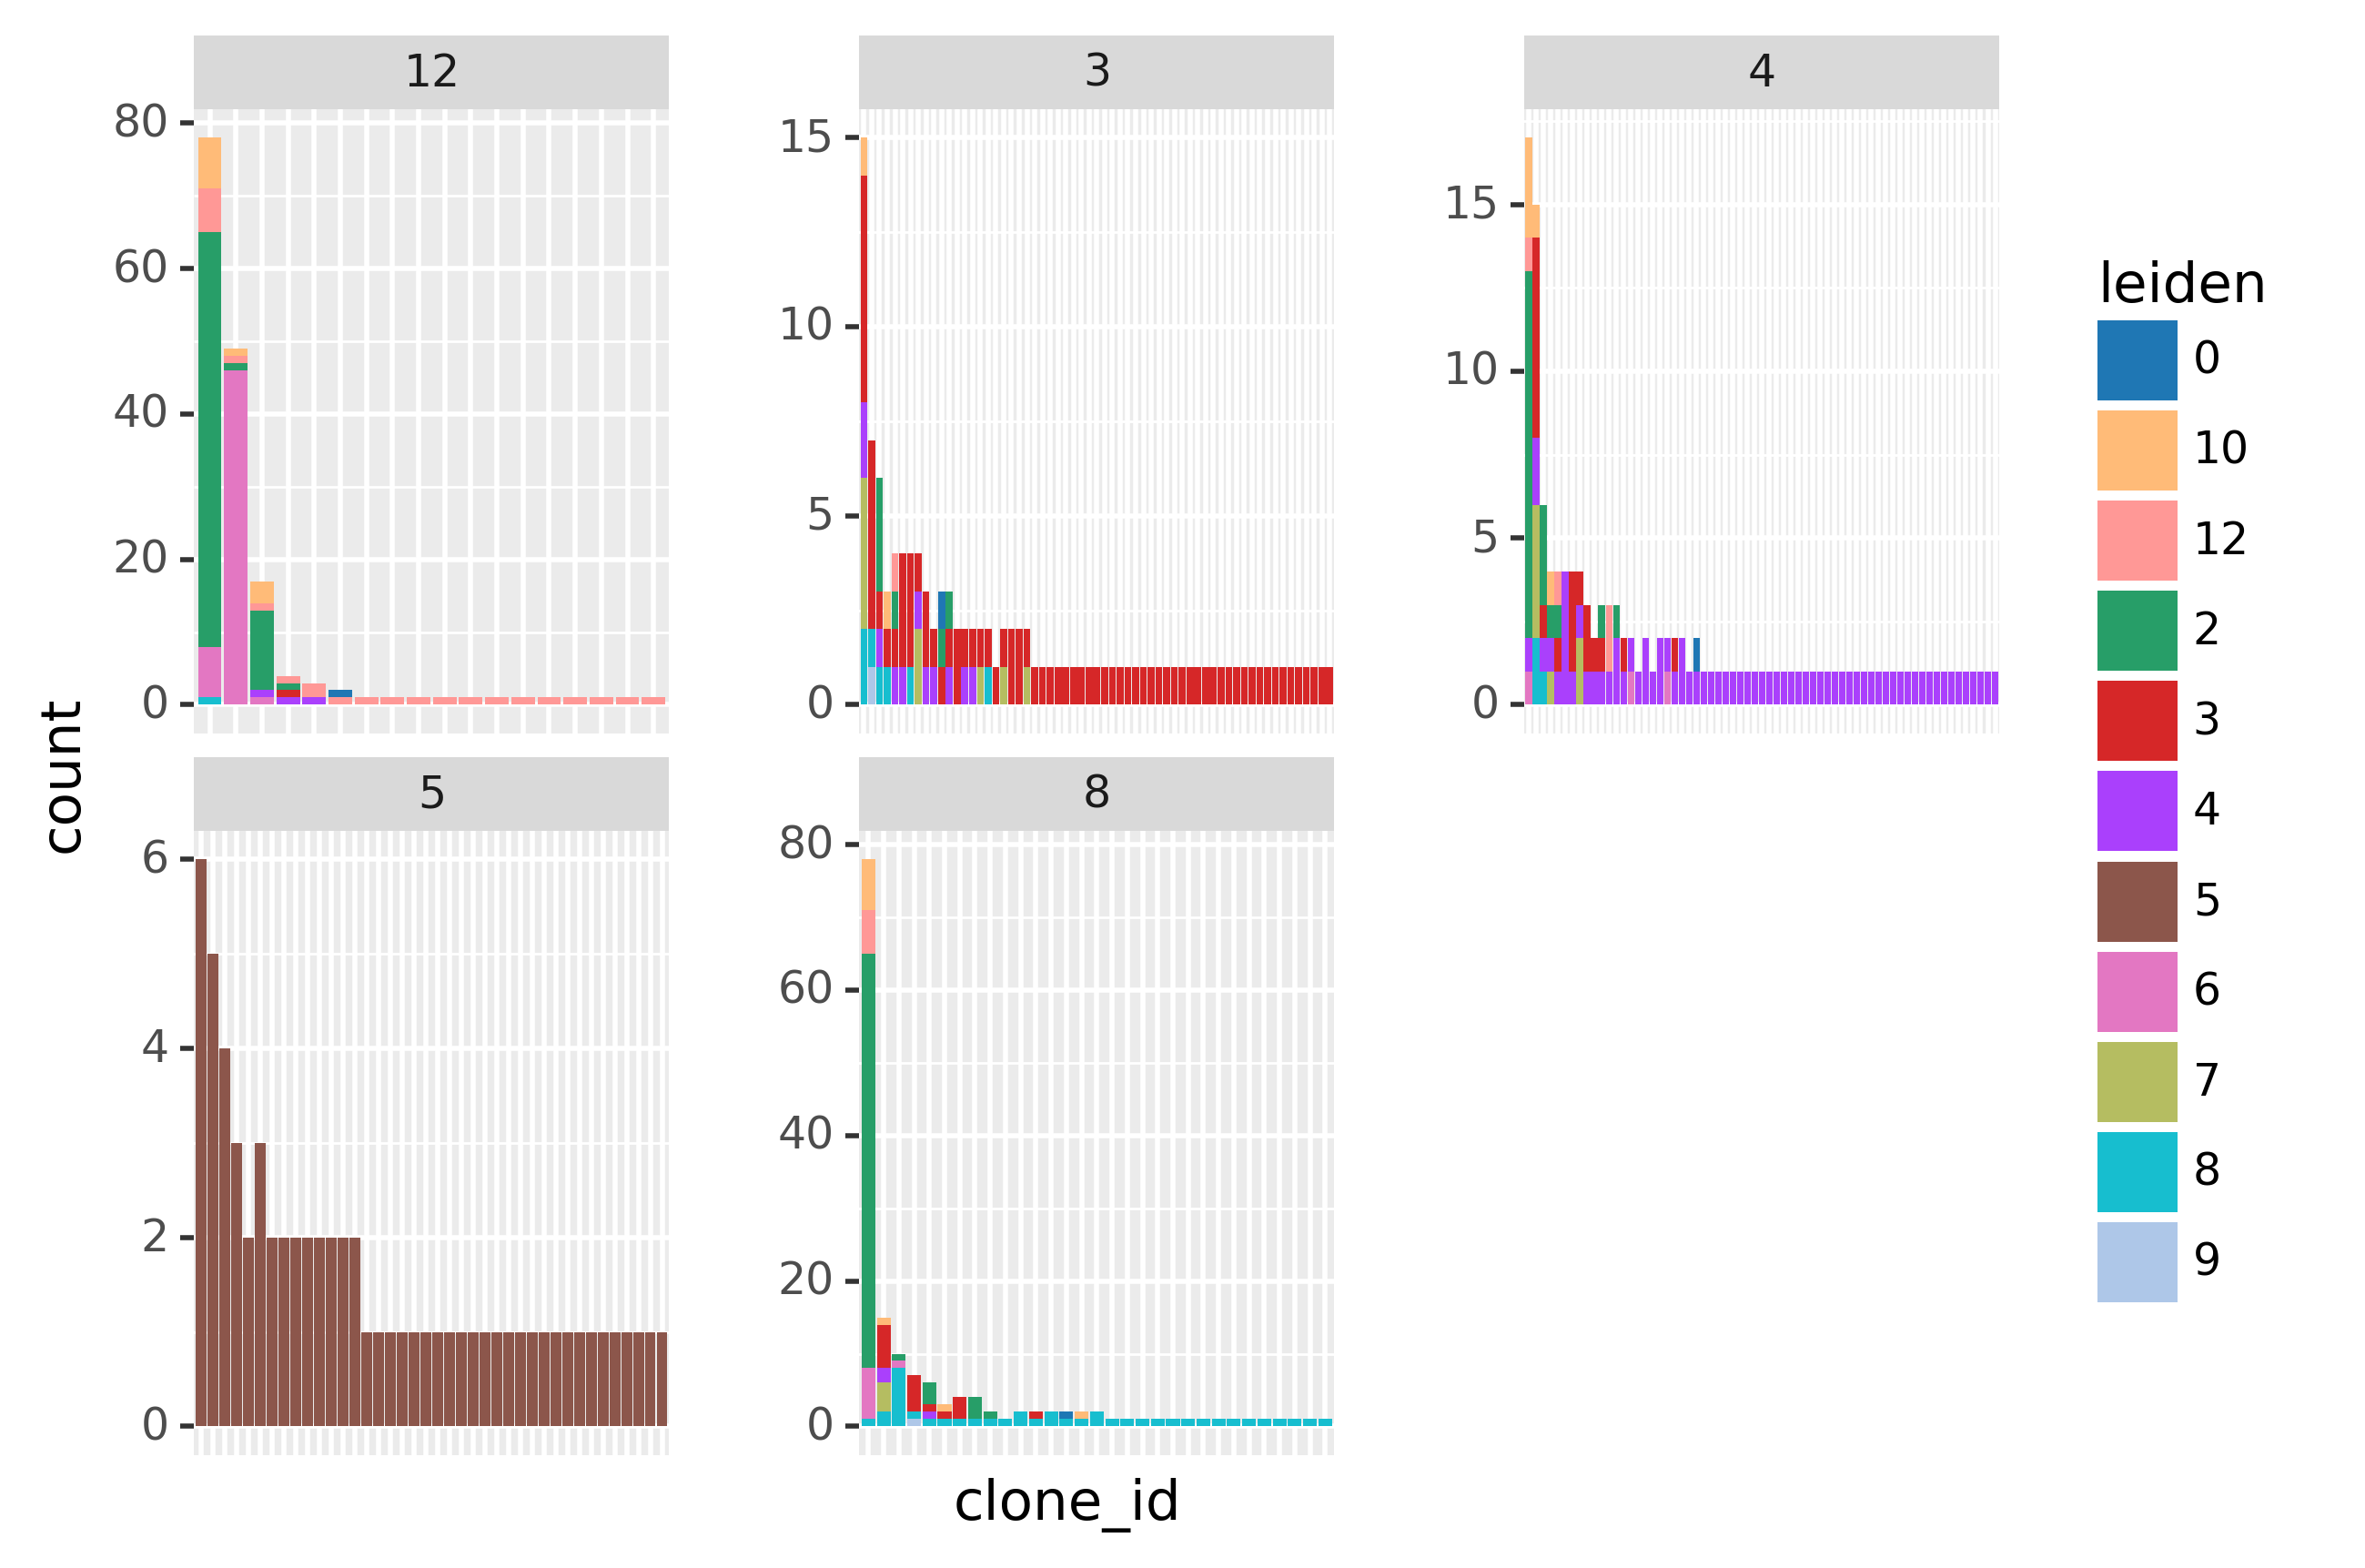

<ggplot: (8746619021565)>

In [157]:
p2 = make_cl_plot("leiden")
p2

In [158]:
ggsave(p2, "paper_figures/supplemental/cd4/clone_sharing_cluster.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/clone_sharing_cluster.pdf
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


## now look into correlations between gene expression and biotin levels

In [31]:
# selecting some interesting genes that correlate strongly with biotin levels
cd4_genes = ["Nkg7", "Ccl5", "Slamf6", "Lef1", "Gzma", "Gzmb", "Id2", "Itgae", "Jaml", "Sell", "Tcf7"]

In [32]:
from scipy.stats import spearmanr

In [33]:
cd4_spearmans = pd.DataFrame()
for s in ad.obs["sample"].unique():
    df =  make_corr_df(ad[ad.obs["sample"] == s])
    df['sample'] = s
    cd4_spearmans = pd.concat([cd4_spearmans, df])

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


In [34]:
cd4_spearmans.head()

gene      corr  interesting gene    i sample
4670   Tmsb10 -0.574919             False  0.0  IEL 4
8666     Tcf7 -0.542788              True  0.1  IEL 4
679    Slamf6 -0.503520              True  0.2  IEL 4
6161  Tspan32 -0.495848             False  0.3  IEL 4
6974  Izumo1r -0.480384             False  0.4  IEL 4

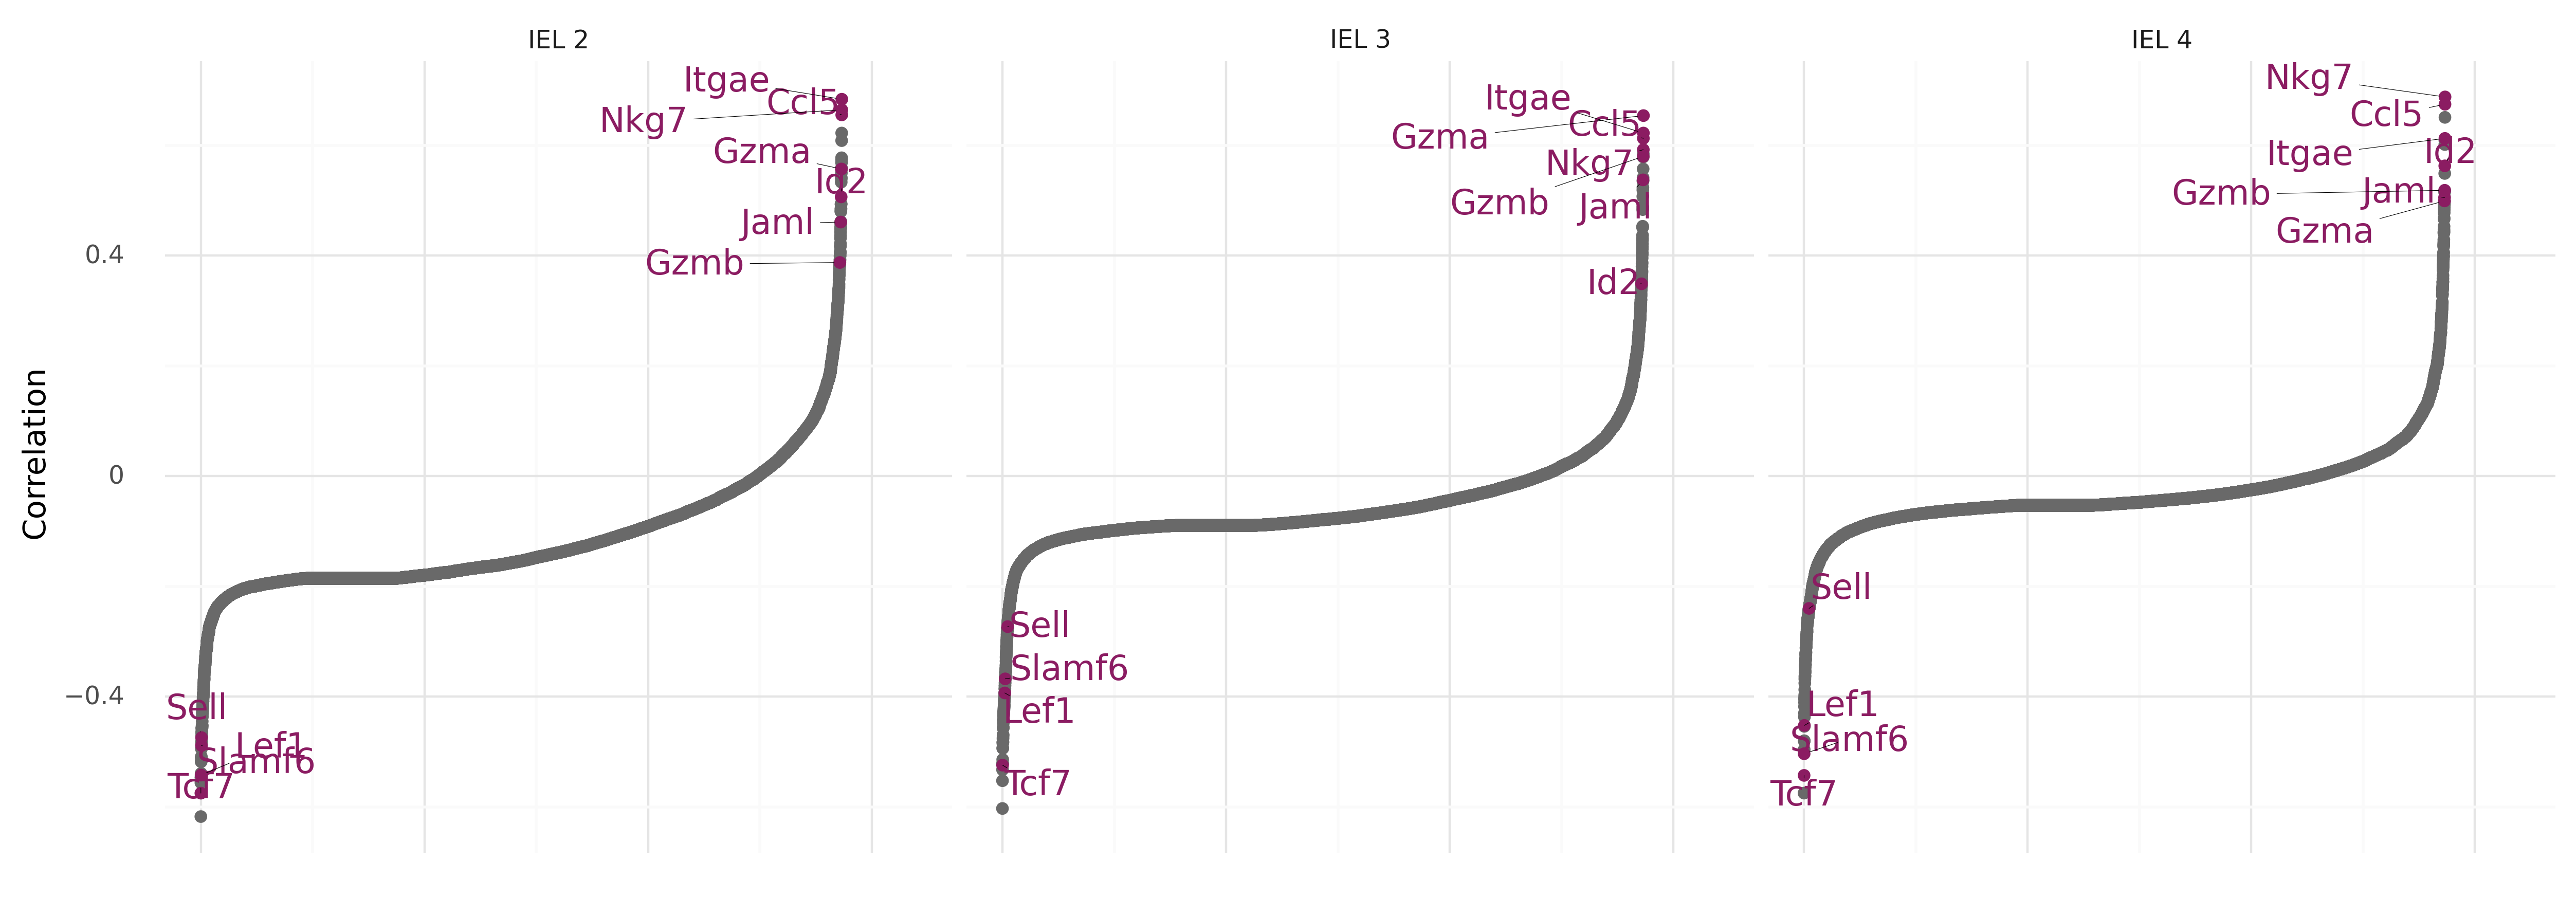

<ggplot: (8746919618557)>

In [35]:
cd4_supp = make_corr_plot(cd4_spearmans) + facet_wrap("~ sample") + theme(figure_size=(15, 5))
cd4_supp

In [36]:
ggsave(cd4_supp, "paper_figures/supplemental/cd4/sample_cd4_biotin_corrs.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 15 x 5 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/sample_cd4_biotin_corrs.pdf


In [37]:
testing_corrs = cd4_spearmans.pivot(index = "gene", columns = "sample", values = "corr")
testing_corrs.head()

sample            IEL 2     IEL 3     IEL 4
gene                                       
0610009B22Rik -0.176720 -0.062415 -0.021278
0610009L18Rik -0.073334 -0.045192 -0.068122
0610010F05Rik -0.161953 -0.097071 -0.033670
0610010K14Rik -0.016378  0.062774 -0.210598
0610012G03Rik -0.123888 -0.014490  0.024517

In [38]:
spearmanr(testing_corrs["IEL 2"], testing_corrs["IEL 3"])

SpearmanrResult(correlation=0.6272250655254846, pvalue=0.0)

In [39]:
spearmanr(testing_corrs["IEL 2"], testing_corrs["IEL 4"])

SpearmanrResult(correlation=0.4933630694410591, pvalue=0.0)

In [40]:
spearmanr(testing_corrs["IEL 3"], testing_corrs["IEL 4"])

SpearmanrResult(correlation=0.46825508532439014, pvalue=0.0)

In [41]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 2"], 
          testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 3"])

SpearmanrResult(correlation=0.691360868922745, pvalue=1.162682437299687e-217)

In [42]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 4"]) > 0.2)]["IEL 2"], 
          testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 4"]) > 0.2)]["IEL 4"])

SpearmanrResult(correlation=0.6650264772833863, pvalue=2.3965950935329676e-196)

In [43]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 4"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 4"], 
          testing_corrs[(abs(testing_corrs["IEL 4"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 3"])

SpearmanrResult(correlation=0.7870537137139214, pvalue=5.3083526861956014e-120)

In [44]:
cd4_spearman_df = make_corr_df(ad)

## <font color = purple> Main figure

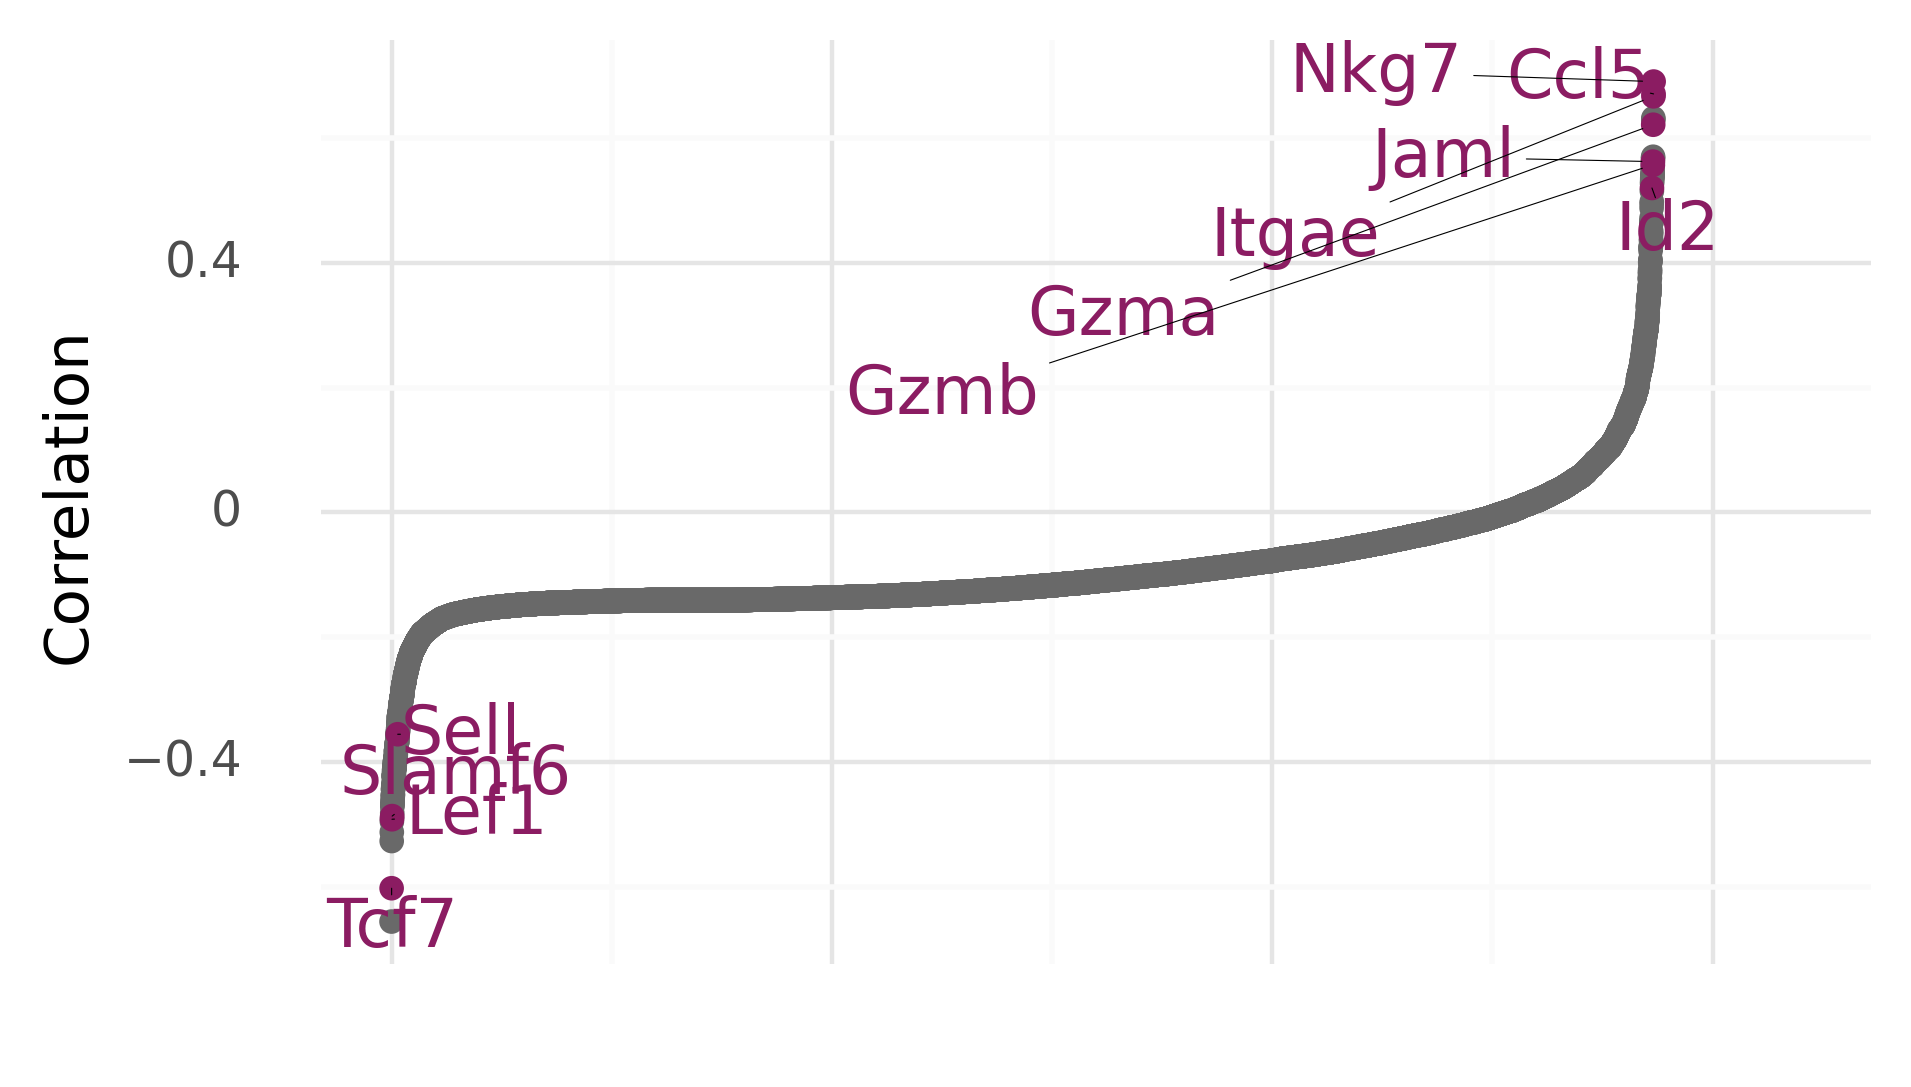

<ggplot: (8746919124776)>

In [45]:
p = make_corr_plot(cd4_spearman_df)
p

In [46]:
ggsave(p, "paper_figures/corrs_panel_5.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/corrs_panel_5.pdf


## supplemental figure: remove the conventional clusters, do we still see these correlations?

In [47]:
np.sum(ad.obs["cd4 annotation"].isna())

0

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


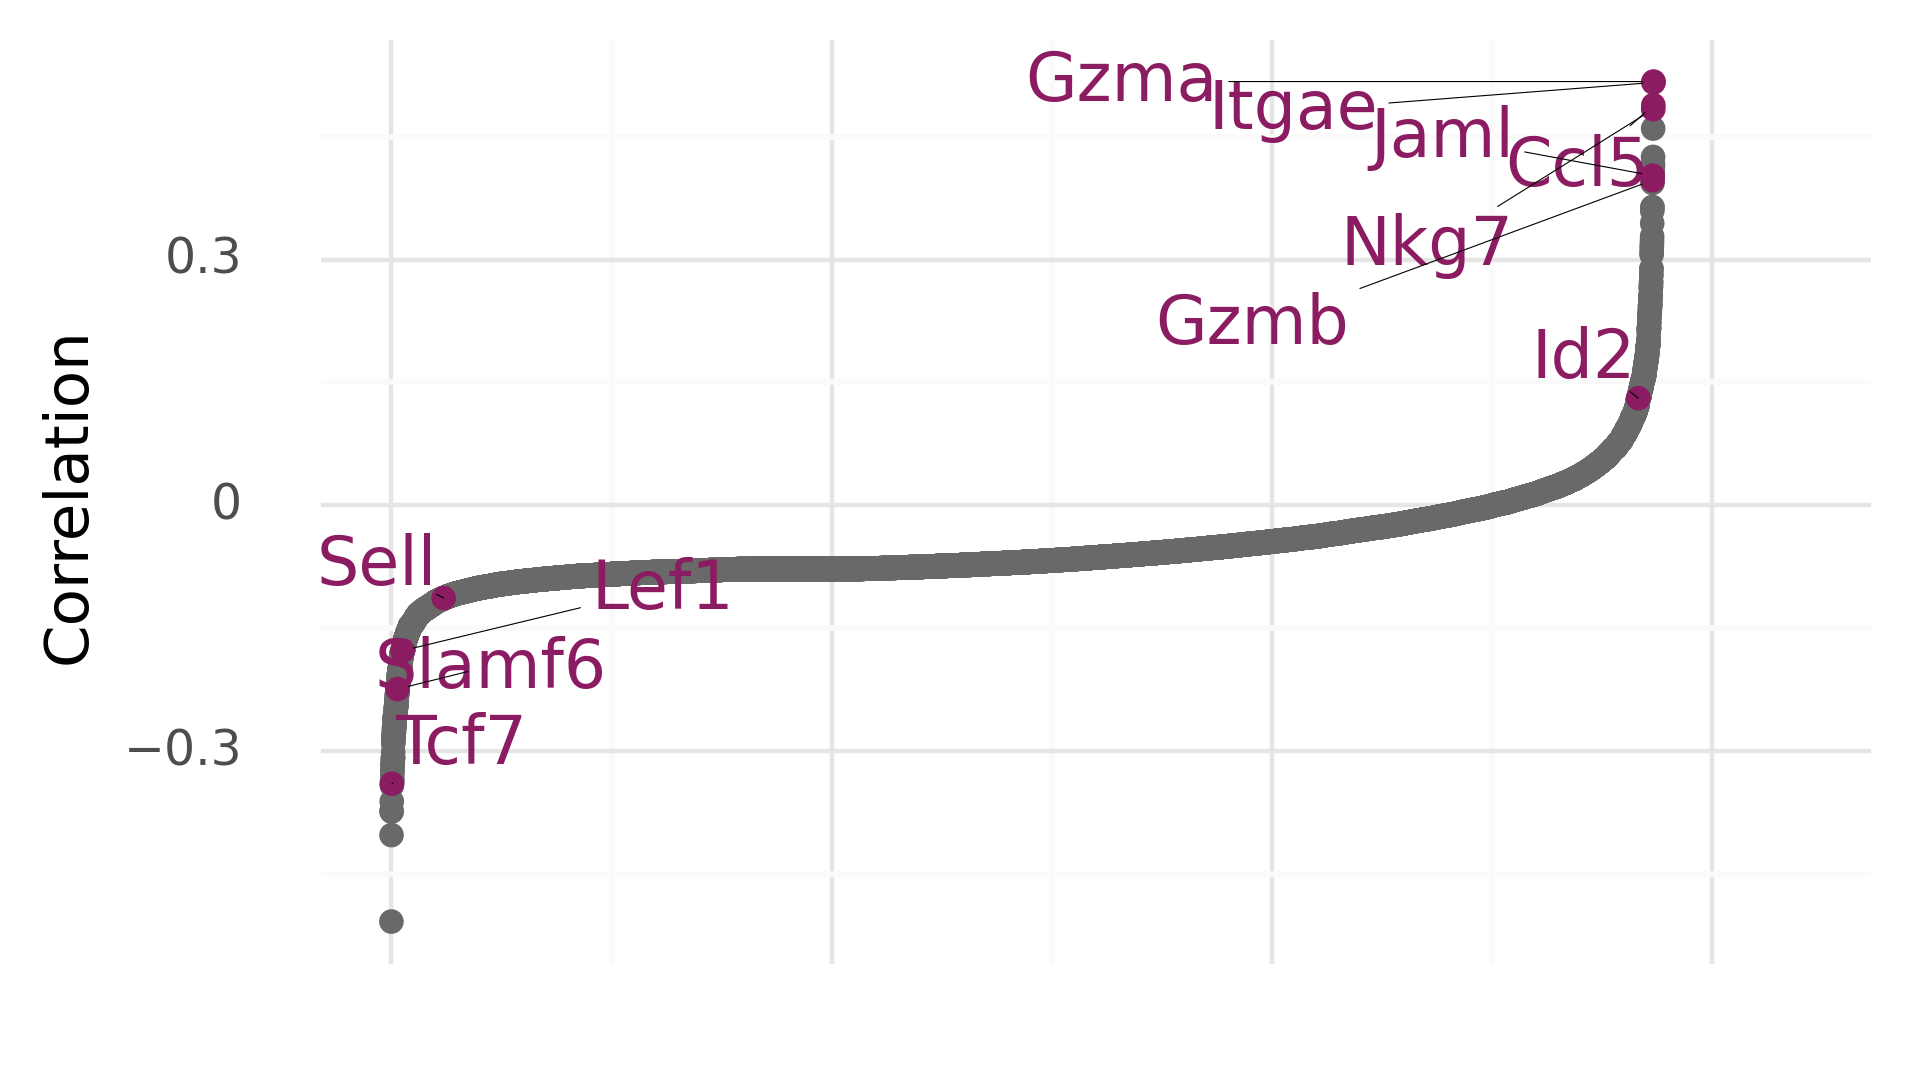

<ggplot: (8746886885690)>

In [50]:
non_conv_spearman_df = make_corr_df(ad[~ad.obs["cd4 annotation"].str.startswith("Conventional CD4")])
p2 = make_corr_plot(non_conv_spearman_df)
p2

In [51]:
ggsave(p2, "paper_figures/supplemental/cd4/no_conv_cd4_biotin_corrs.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/no_conv_cd4_biotin_corrs.pdf


## main figure

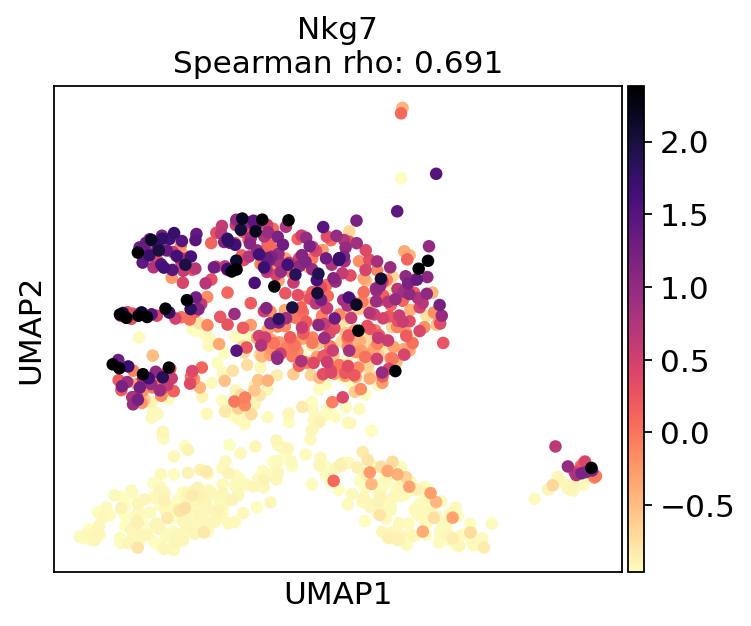

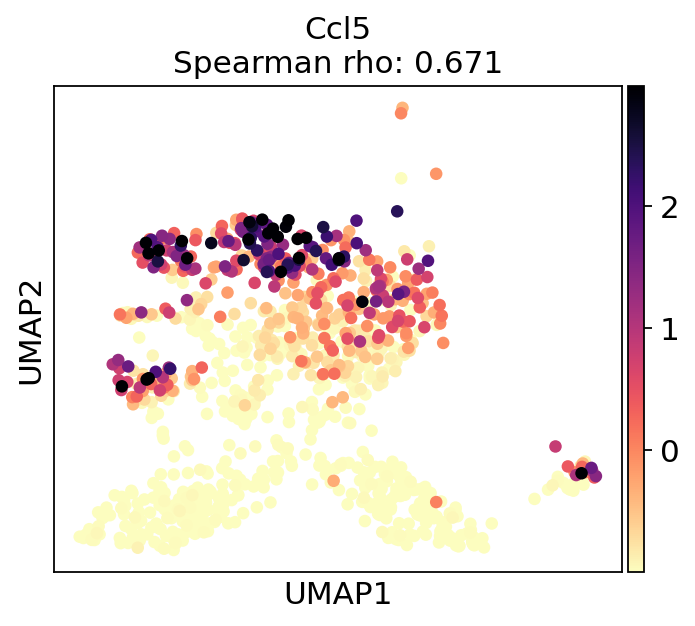

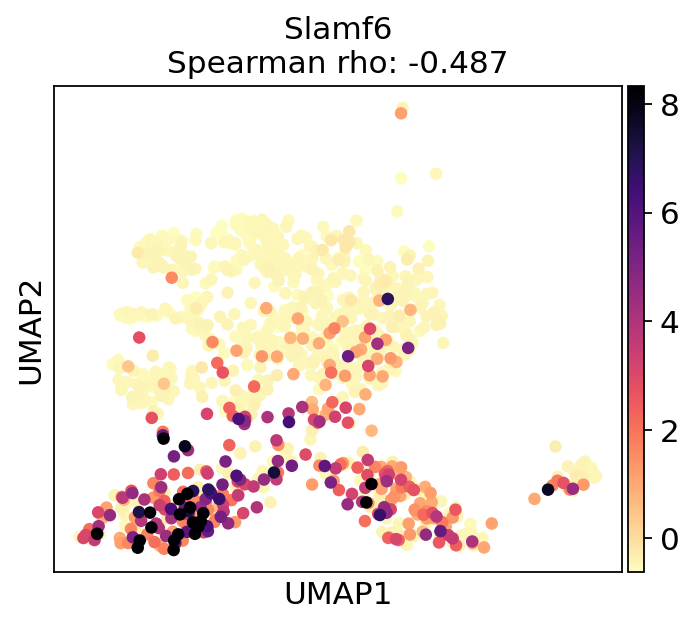

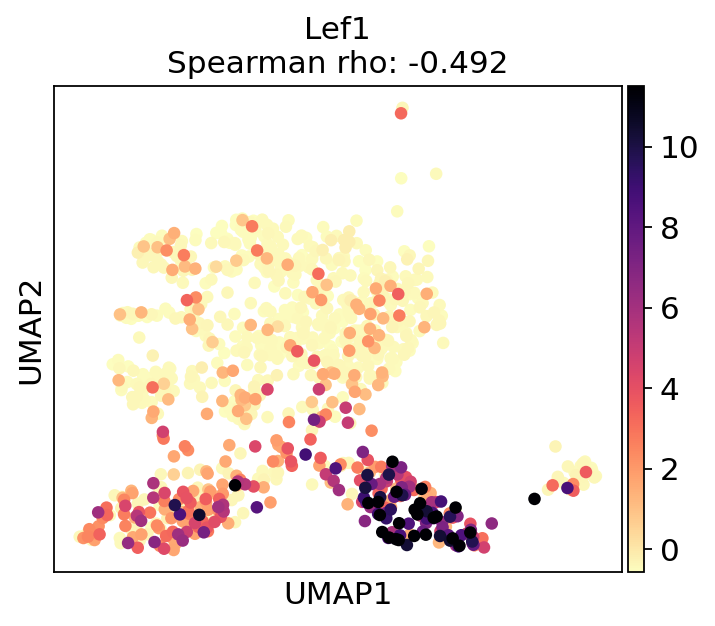

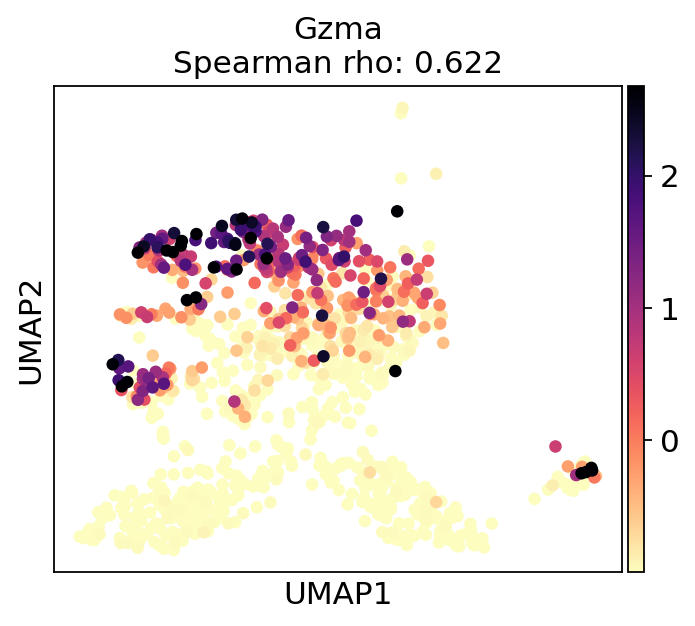

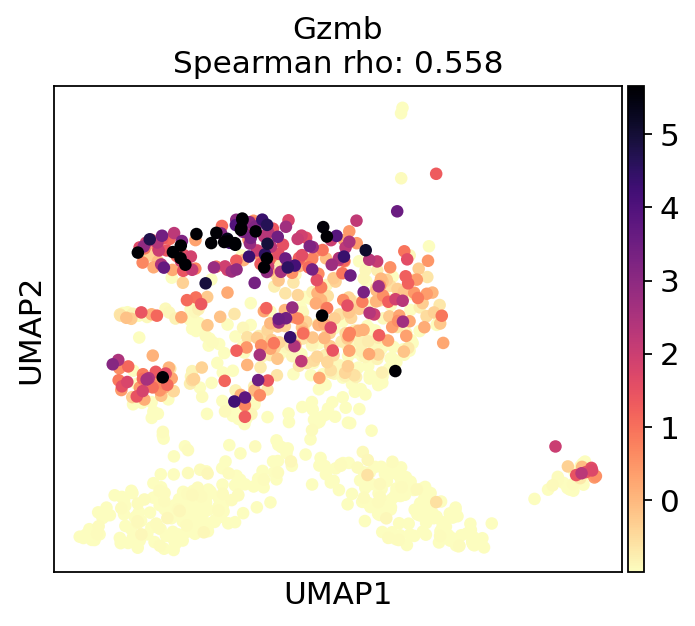

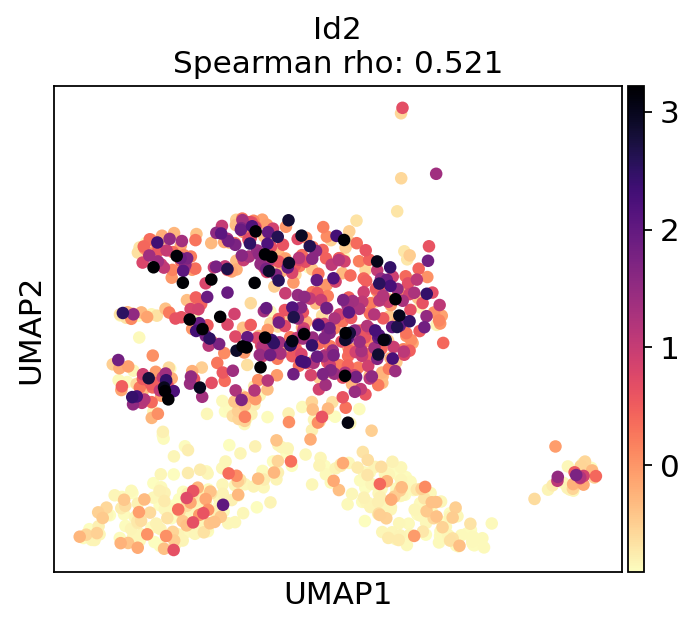

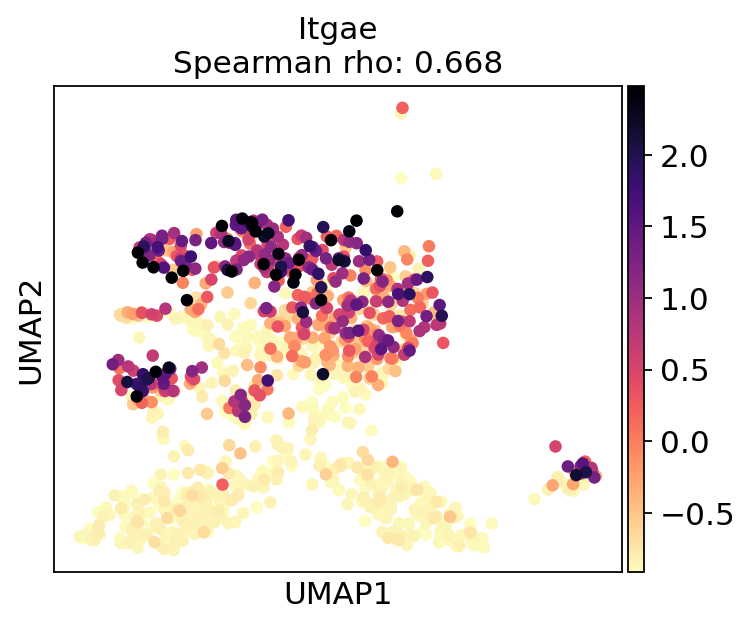

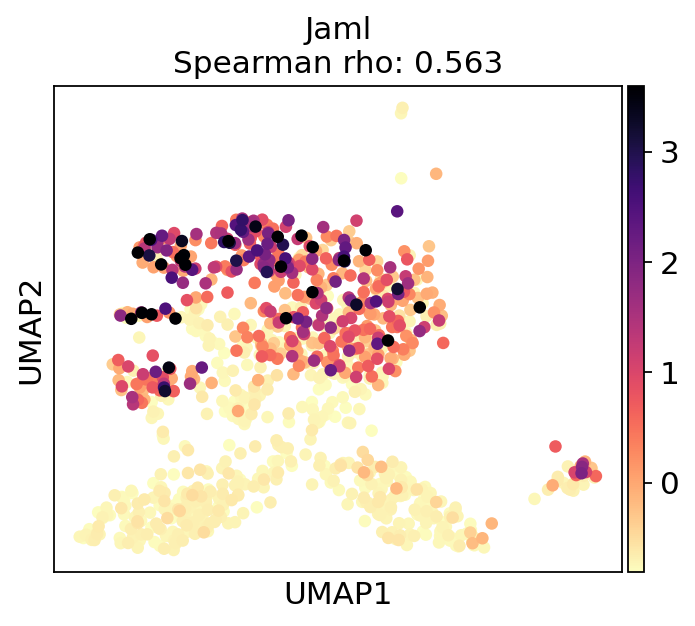

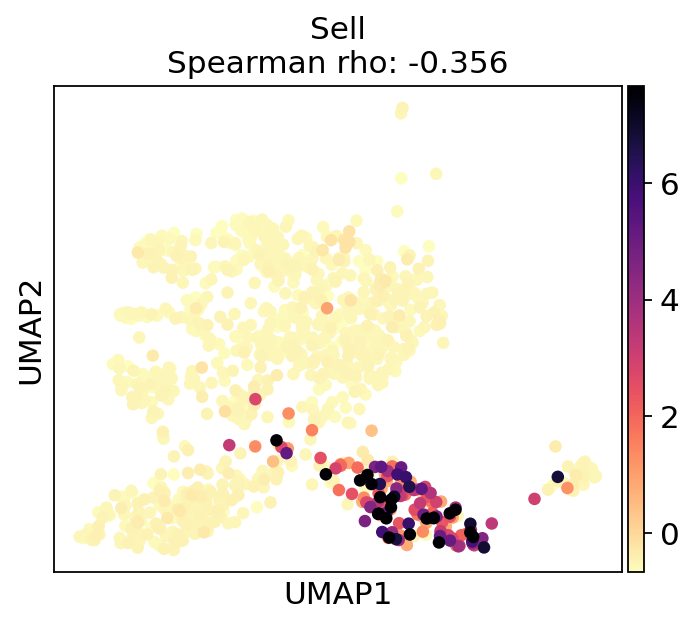

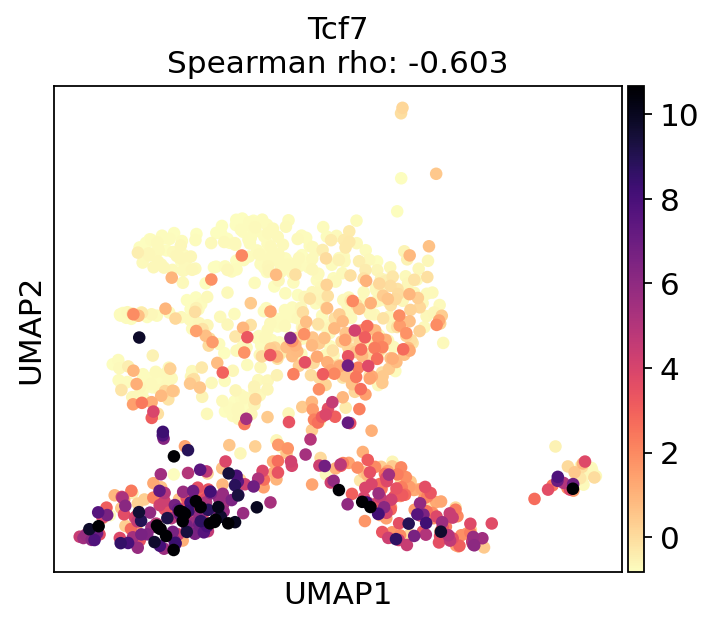

In [166]:
## plot important genes with spearman correlations 
for g in cd4_genes:
    corr = np.round(cd4_spearman_df[cd4_spearman_df["gene"] == g]["corr"].values[0], 3)
    sc.pl.umap(ad, color = g, vmin = "p2", vmax="p98", layer = "pearson_theta_1", cmap="magma_r",
               title = "%s\nSpearman rho: %s"%(g, corr), save="_panel6_%s.pdf"%g)

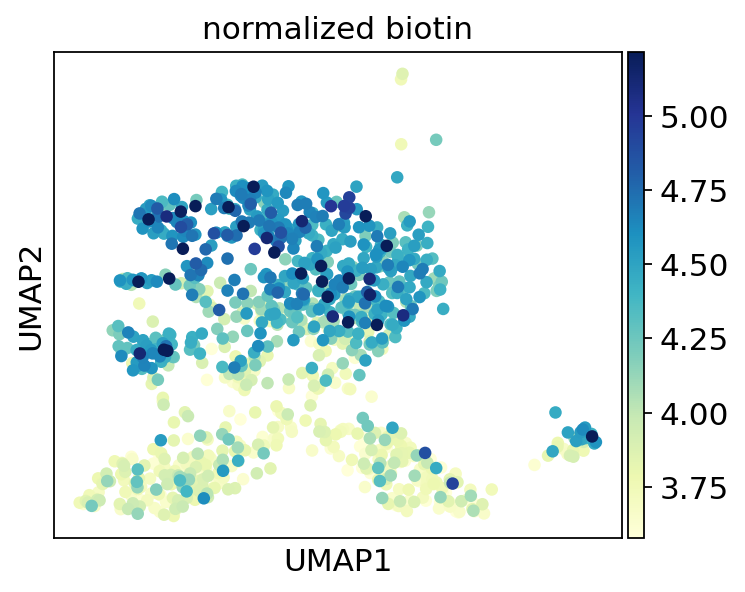

In [167]:
sc.pl.umap(ad, color = "normalized biotin", vmin = "p2", vmax="p98", color_map = "YlGnBu",
           save="_panel6_biotin.pdf")

In [49]:
print("here")

here
